In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1 as ff1
from fastf1.core import Laps
from fastf1 import plotting
from datetime import timedelta
from timple.timedelta import strftimedelta
from fastf1 import plotting
import datetime


In [3]:
ff1.Cache.enable_cache('../cache') 


In [4]:

bahrain = ff1.get_session(2023, 'Bahrain', 'R')
plotting.setup_mpl()
bahrain.load()


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/thalles/.local/lib/python3.11/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/home/thalles/.local/lib/python3.11/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/home/thalles/.local/lib/python3.11/site-packages/fastf1/core.py:1415: FutureWarning: In a f

## Estratégia de Pneus

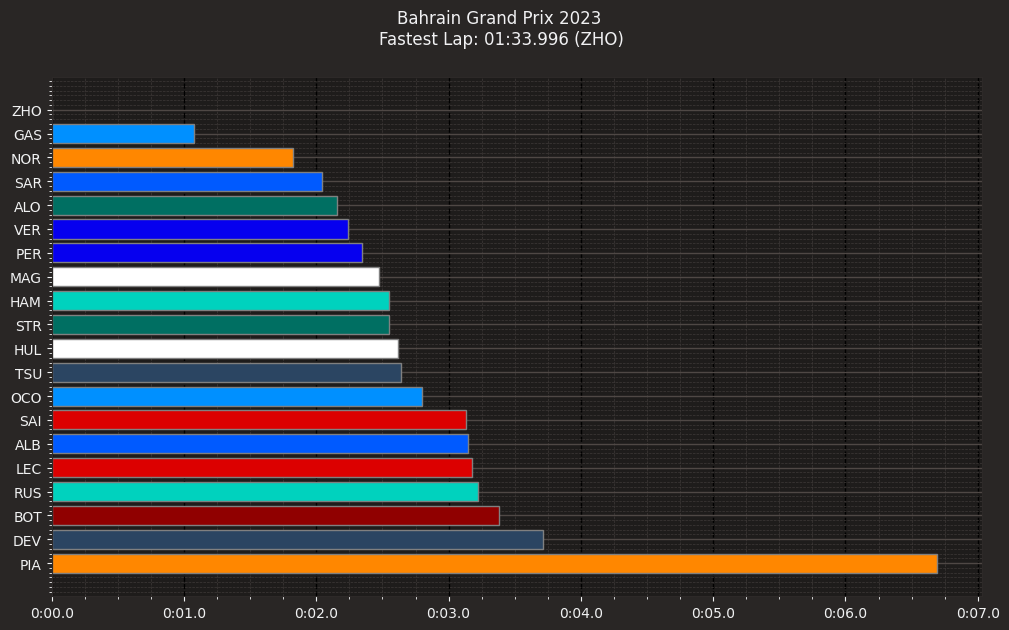

In [5]:
list_fastest_laps = list()    
for drv in bahrain.results['Abbreviation']:
        drvs_fastest_lap = bahrain.laps.pick_driver(drv).pick_fastest()
        list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

    # plot is nicer to look at and more easily understandable if we just plot the time differences.
    #  Therefore we subtract the fastest lap time from all other lap times.
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)


    
fig, ax = plt.subplots(figsize=(12, 6.75))
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

    # show fastest at the top
ax.invert_yaxis()

    # draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{bahrain.event['EventName']} {bahrain.event.year} \n"
                f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

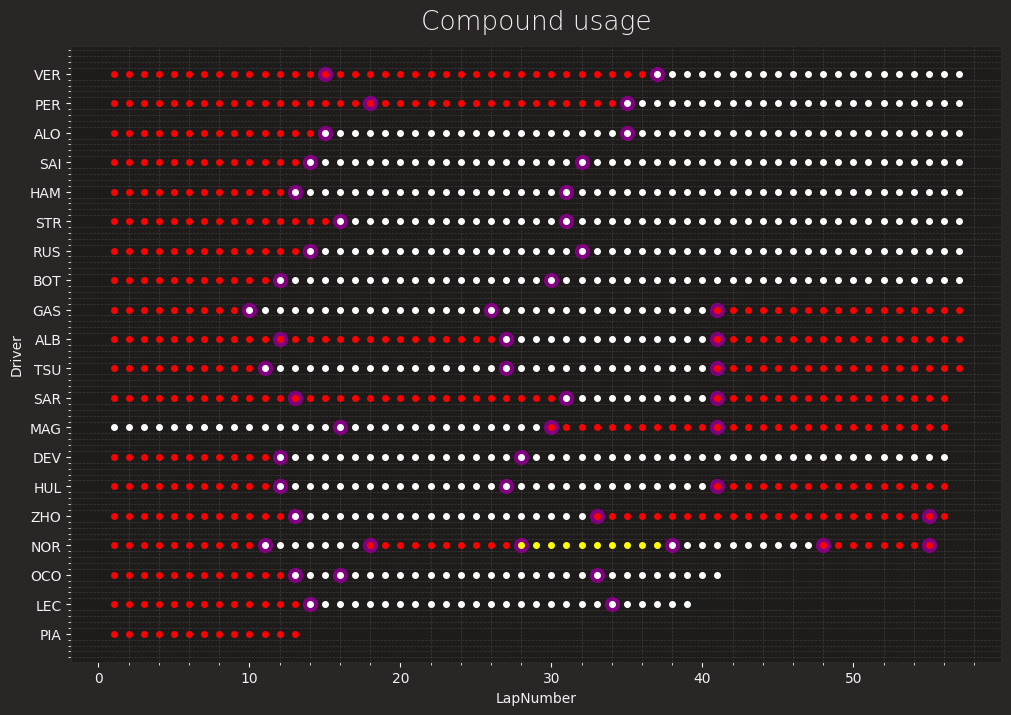

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

pitstops = bahrain.laps[['LapNumber', 'Stint', 'Driver']].copy()
pitstops['Pitstop'] = ~pitstops.Stint.eq(pitstops.Stint.shift())
pitstops = pitstops[pitstops.Pitstop] 
pitstops = pitstops[pitstops.LapNumber > 1]
pitstops.plot.scatter('LapNumber', 'Driver', ax=ax, color='purple', s=100)

df = bahrain.laps[['Driver', 'LapNumber', 'Compound']]
df = pd.merge(bahrain.results[['Abbreviation']], df, left_on='Abbreviation', right_on='Driver')
for tyre,color in zip(['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET'], ['red', 'yellow', 'white', 'green', 'blue']):
   df = bahrain.laps[bahrain.laps.Compound == tyre][['Driver', 'LapNumber', 'Compound']]
   df.plot.scatter('LapNumber', 'Driver', ax=ax, color=color, s=16)
ax.invert_yaxis()
ax.set_title('Compound usage')
plt.savefig('Bahrain_Strategy.png', dpi=350)
plt.show()

In [7]:
ver_laps = bahrain.laps.pick_driver('VER')
# ver_laps['LapTimeSeconds'] = ver_laps['LapTime'].dt.total_seconds()


#### Gap To Pole

/tmp/ipykernel_7449/2953132195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ver_laps['LapTimeSeconds'] = ver_laps['Time'].dt.total_seconds()
/tmp/ipykernel_7449/2953132195.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
/tmp/ipykernel_7449/2953132195.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

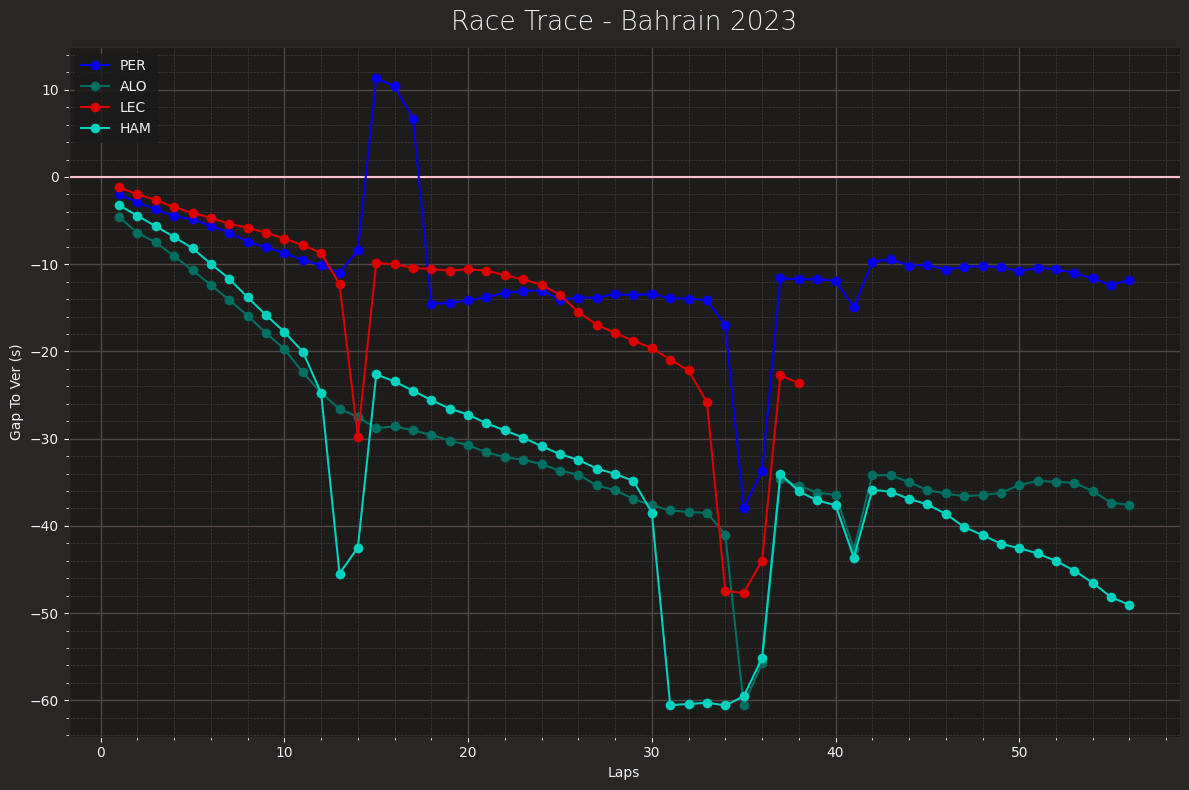

In [8]:


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ver_laps['LapTimeSeconds'] = ver_laps['Time'].dt.total_seconds()

ax.axhline(0, color= 'pink')
for driver in ['PER', 'ALO', 'LEC', 'HAM']:
    driver_laps = bahrain.laps.pick_driver(driver)
    driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
    color = ff1.plotting.team_color(driver_laps['Team'].reset_index(drop = True)[0])
    plt.plot(driver_laps['LapNumber'], ver_laps['LapTimeSeconds'].reset_index(drop=True)[:len(driver_laps['LapTimeSeconds']) - 1] - driver_laps['LapTimeSeconds'].reset_index(drop=True), marker = 'o', label= driver, color = color)

ax.legend(loc="upper left")
ax.set(xlabel='Laps', ylabel= 'Gap To Ver (s)')
plt.title("Race Trace - Bahrain 2023")
plt.savefig('Gap_To_Pole_Bahrain.png', dpi=350)

### Gap To Virtual Driver

/tmp/ipykernel_7449/2148311007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
/tmp/ipykernel_7449/2148311007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
/tmp/ipykernel_7449/2148311007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

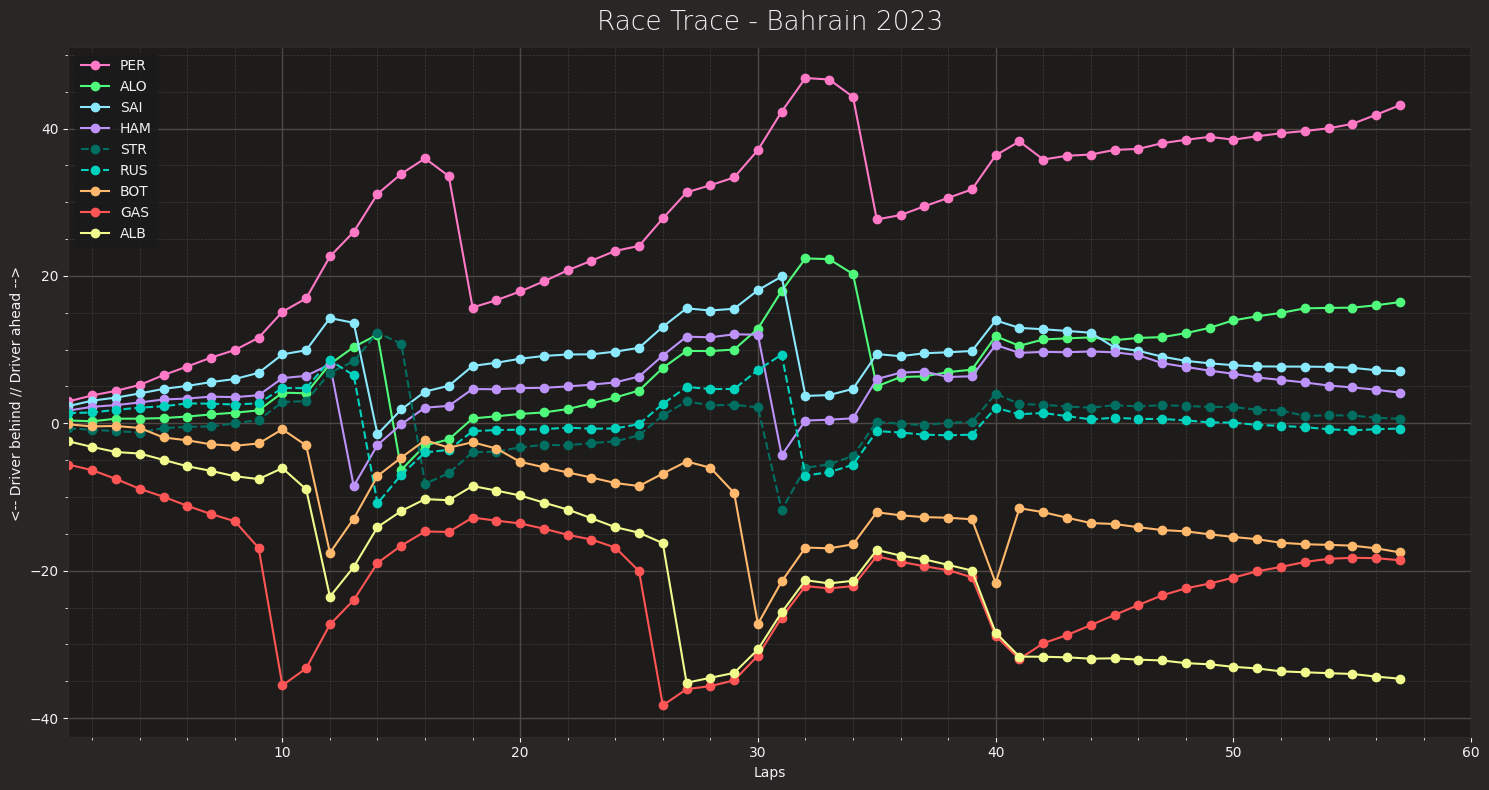

In [9]:
average_driver_laptime = []
for driver in bahrain.results['Abbreviation'][1:10]:
    driver_laps = bahrain.laps.pick_driver(driver)
    driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
    average_driver_laptime.append(driver_laps['LapTimeSeconds'].reset_index(drop = True))
virtual_driver = pd.DataFrame(average_driver_laptime)

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
color_list = []

for driver in bahrain.results['Abbreviation'][1:10]:
    driver_laps = bahrain.laps.pick_driver(driver)
    driver_laps['LapTimeSeconds'] = driver_laps['Time'].dt.total_seconds()
    color = ff1.plotting.team_color(driver_laps['Team'].reset_index(drop = True)[0])
    if color in color_list:
        ax.plot(driver_laps['LapNumber'], virtual_driver.mean().reset_index(drop=True)[:len(driver_laps['LapTimeSeconds'])] - driver_laps['LapTimeSeconds'].reset_index(drop=True), marker = 'o', label= driver, color = color, ls='--')
    else:
        ax.plot(driver_laps['LapNumber'], virtual_driver.mean().reset_index(drop=True)[:len(driver_laps['LapTimeSeconds'])] - driver_laps['LapTimeSeconds'].reset_index(drop=True), marker = 'o', label= driver)
    color_list.append(color)

ax.legend(loc="upper left")
ax.set(xlabel='Laps', ylabel= '<-- Driver behind // Driver ahead --> ')
ax.set_xlim(xmin = 1 , xmax= 60)
plt.title("Race Trace - Bahrain 2023")
plt.savefig('Gap_To_Virtual_Driver_Bahrain.png', dpi=350)
    

In [10]:
bahrain.results

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
1,1,M VERSTAPPEN,VER,Red Bull Racing,3671C6,Max,Verstappen,Max Verstappen,1.0,1.0,NaT,NaT,NaT,0 days 01:33:56.736000,Finished,25.0
11,11,S PEREZ,PER,Red Bull Racing,3671C6,Sergio,Perez,Sergio Perez,2.0,2.0,NaT,NaT,NaT,0 days 01:34:08.723000,Finished,18.0
14,14,F ALONSO,ALO,Aston Martin,358C75,Fernando,Alonso,Fernando Alonso,3.0,5.0,NaT,NaT,NaT,0 days 01:34:35.373000,Finished,15.0
55,55,C SAINZ,SAI,Ferrari,F91536,Carlos,Sainz,Carlos Sainz,4.0,4.0,NaT,NaT,NaT,0 days 01:34:44.788000,Finished,12.0
44,44,L HAMILTON,HAM,Mercedes,6CD3BF,Lewis,Hamilton,Lewis Hamilton,5.0,7.0,NaT,NaT,NaT,0 days 01:34:47.713000,Finished,10.0
18,18,L STROLL,STR,Aston Martin,358C75,Lance,Stroll,Lance Stroll,6.0,8.0,NaT,NaT,NaT,0 days 01:34:51.238000,Finished,8.0
63,63,G RUSSELL,RUS,Mercedes,6CD3BF,George,Russell,George Russell,7.0,6.0,NaT,NaT,NaT,0 days 01:34:52.609000,Finished,6.0
77,77,V BOTTAS,BOT,Alfa Romeo,C92D4B,Valtteri,Bottas,Valtteri Bottas,8.0,12.0,NaT,NaT,NaT,0 days 01:35:09.383000,Finished,4.0
10,10,P GASLY,GAS,Alpine,2293D1,Pierre,Gasly,Pierre Gasly,9.0,20.0,NaT,NaT,NaT,0 days 01:35:10.489000,Finished,2.0
23,23,A ALBON,ALB,Williams,37BEDD,Alexander,Albon,Alexander Albon,10.0,15.0,NaT,NaT,NaT,0 days 01:35:26.510000,Finished,1.0
